In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
import meteostat
import numpy as np
import pandas as pd
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.deterministic import DeterministicProcess

from endoutbreakvbd.utils import month_start_xticks


In [3]:
df = (
    meteostat.Daily(
        loc=[16239],
        start=datetime(2010, 1, 1),
        end=datetime(2024, 12, 31),
    )
    .fetch()[["tavg"]]
    .rename({"tavg": "temperature"}, axis=1)
    .rename_axis("date")
)
df.head()

,temperature
date,
2010-01-02,8.9
2010-01-03,4.3
2010-01-04,6.6
2010-01-05,10.3
2010-01-06,10.6


In [4]:
df_full = pd.DataFrame(
    {"temperature": np.nan},
    index=pd.date_range("2010-01-01", "2024-12-31"),
).rename_axis("date")
df_full.loc[df.index, "temperature"] = df["temperature"]

In [5]:
dp = DeterministicProcess(
    index=df_full.index,
    constant=True,
    fourier=2,
    period=365.25,
    drop=True,
)
X_full = dp.in_sample()
y_full = df_full["temperature"]

obs_mask = y_full.notna()
X_train = X_full.loc[obs_mask]
y_train = y_full.loc[obs_mask]
model = OLS(y_train, X_train).fit()

df_smoothed = pd.DataFrame({"temperature": model.predict(X_full)}, index=df_full.index)
df_smoothed.head()


,temperature
date,
2010-01-01,8.578410
2010-01-02,8.546366
2010-01-03,8.516446
2010-01-04,8.488633
2010-01-05,8.462908


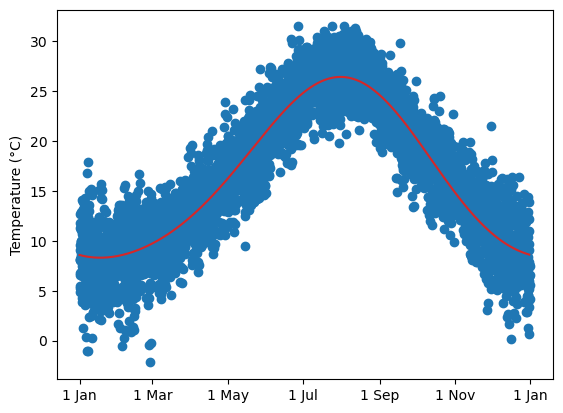

In [6]:
fig, ax = plt.subplots()
ax.scatter(
    df.index.dayofyear,
    df["temperature"],
    color="tab:blue",
)
ax.plot(
    df_smoothed[:365].index.dayofyear,
    df_smoothed[:365]["temperature"],
    color="tab:red",
)

month_start_xticks(ax, interval_months=2)
ax.set_ylabel("Temperature (°C)");

<Axes: xlabel='date'>

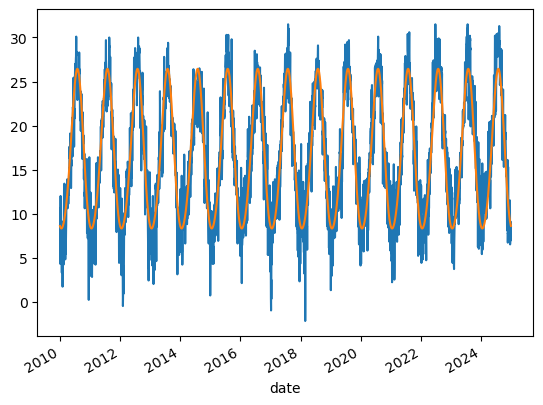

In [7]:
fig, ax = plt.subplots()
df["temperature"].plot(ax=ax)
df_smoothed["temperature"].plot(ax=ax)

In [8]:
df_rolling = df[["temperature"]].rolling(window=14, center=False).mean()

In [9]:
df_2017 = df.loc["2017"].assign(
    temperature_smoothed=df_smoothed.loc["2017", "temperature"],
    temperature_rolling=df_rolling.loc["2017", "temperature"],
)

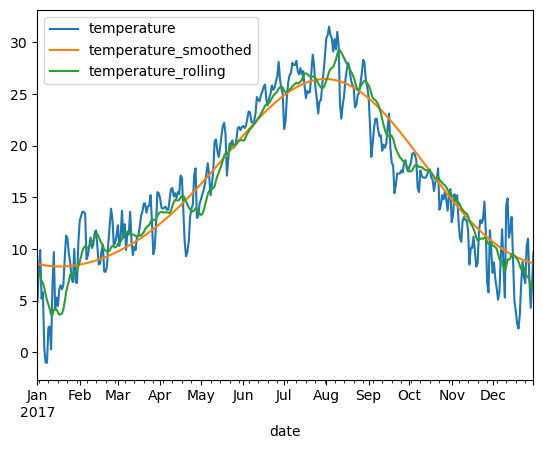

In [10]:
df_2017.plot(y=["temperature", "temperature_smoothed", "temperature_rolling"]);

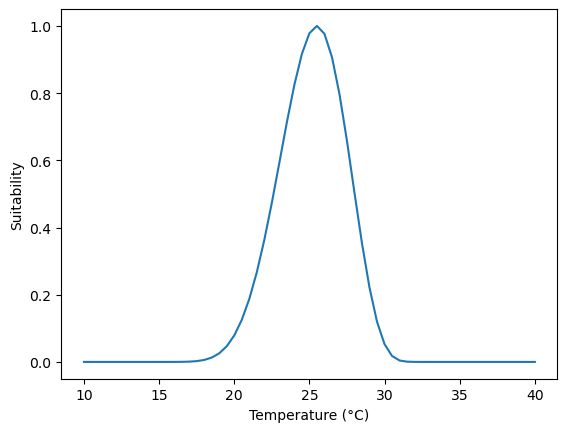

In [11]:
temperature_grid = np.linspace(10, 40, 61)
suitability_grid = (
    np.array(
        [
            0.00000000e00,
            0.00000000e00,
            1.88203984e-08,
            1.28367618e-07,
            5.36961844e-07,
            2.82007101e-06,
            1.28234033e-05,
            5.25931083e-05,
            1.82882567e-04,
            5.50222548e-04,
            1.48801416e-03,
            3.62102778e-03,
            7.92083800e-03,
            1.57431781e-02,
            2.88100329e-02,
            4.86355377e-02,
            7.66192219e-02,
            1.13479057e-01,
            1.59883423e-01,
            2.15867501e-01,
            2.80759580e-01,
            3.53556862e-01,
            4.32786966e-01,
            5.16530769e-01,
            6.02553457e-01,
            6.88071907e-01,
            7.69834160e-01,
            8.44406132e-01,
            9.08117700e-01,
            9.57439287e-01,
            9.89023789e-01,
            1.00000000e00,
            9.88217659e-01,
            9.52537702e-01,
            8.92959231e-01,
            8.10907665e-01,
            7.09457680e-01,
            5.93673840e-01,
            4.69879650e-01,
            3.45600684e-01,
            2.29671637e-01,
            1.32825400e-01,
            6.50191949e-02,
            2.73829517e-02,
            1.02714042e-02,
            3.48809148e-03,
            1.03983518e-03,
            3.27940090e-04,
            7.74962840e-05,
            1.17503236e-05,
            0.00000000e00,
            0.00000000e00,
            0.00000000e00,
            0.00000000e00,
            0.00000000e00,
            0.00000000e00,
            0.00000000e00,
            0.00000000e00,
            0.00000000e00,
            0.00000000e00,
            0.00000000e00,
        ]
    )
    ** 2
)
plt.plot(temperature_grid, suitability_grid)
plt.xlabel("Temperature (°C)")
plt.ylabel("Suitability");

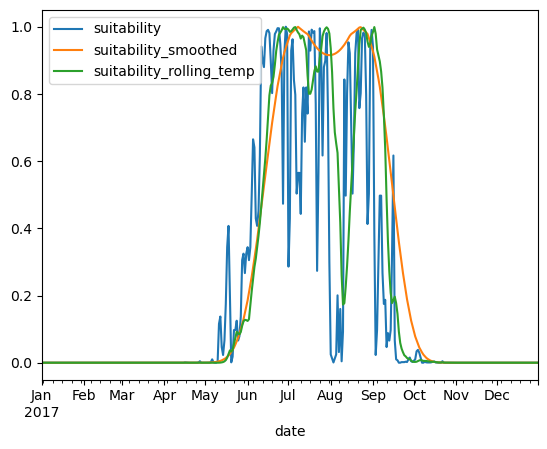

In [12]:
df_2017 = df_2017.assign(
    suitability=np.interp(
        df_2017["temperature"],
        temperature_grid,
        suitability_grid,
    ),
    suitability_smoothed=np.interp(
        df_2017["temperature_smoothed"],
        temperature_grid,
        suitability_grid,
    ),
    suitability_rolling_temp=np.interp(
        df_2017["temperature_rolling"],
        temperature_grid,
        suitability_grid,
    ),
)
df_2017.plot(y=["suitability", "suitability_smoothed", "suitability_rolling_temp"]);

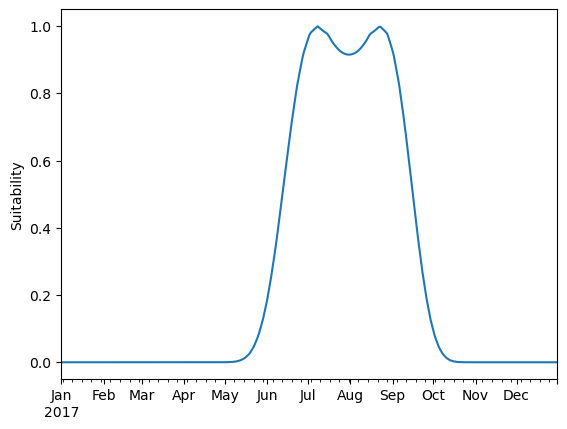

In [17]:
df_2017.plot(y="suitability_smoothed", legend=False, xlabel="", ylabel="Suitability");

In [14]:
df_2017.to_csv("endoutbreakvbd/rome_weather_suitability_2017.csv")